In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package punkt to C:\Users\Vatsal
[nltk_data]     Makodia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Vatsal Makodia\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to C:\Users\Vatsal
[nltk_data]     Makodia\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Vatsal
[nltk_data]     Makodia\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [38]:
plt.style.use('ggplot')
df = pd.read_excel('Twitter_data.xlsx')
print(df.shape)
df = df.head(500)
print(df.shape)

(76, 2)
(76, 2)


In [39]:
df.head()

,Id,Text
0,1,Here at Vadodara you can feel like 20 yrs back...
1,2,Vadodara is one of the biggest city of Gujarat...
2,3,Very FEW International Flights in proportion t...
3,4,"Due to the authorities' incompetence, the city..."
4,5,I am no opposing the news..but the underground...


In [40]:
# review example
example = df['Text'][51]
print(example)

At SAHAJ - Towards Alternatives for Health and Development, Vadodara with my students.


In [41]:
# tokenization - seperate the strings
tokens = nltk.word_tokenize(example)
tokens[0:]
# tokens[:10]

['At',
 'SAHAJ',
 '-',
 'Towards',
 'Alternatives',
 'for',
 'Health',
 'and',
 'Development',
 ',',
 'Vadodara',
 'with',
 'my',
 'students',
 '.']

In [42]:
# part of speech tagging / abbreviation
tagged = nltk.pos_tag(tokens)
tagged [0:]
# tagged[:10]

[('At', 'IN'),
 ('SAHAJ', 'NNP'),
 ('-', ':'),
 ('Towards', 'NNS'),
 ('Alternatives', 'VBZ'),
 ('for', 'IN'),
 ('Health', 'NNP'),
 ('and', 'CC'),
 ('Development', 'NNP'),
 (',', ','),
 ('Vadodara', 'NNP'),
 ('with', 'IN'),
 ('my', 'PRP$'),
 ('students', 'NNS'),
 ('.', '.')]

In [43]:
# takes tokens and groups them into texts
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  At/IN
  (ORGANIZATION SAHAJ/NNP)
  -/:
  (ORGANIZATION Towards/NNS Alternatives/VBZ for/IN Health/NNP)
  and/CC
  (ORGANIZATION Development/NNP)
  ,/,
  (PERSON Vadodara/NNP)
  with/IN
  my/PRP$
  students/NNS
  ./.)


In [44]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [45]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [46]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.008931124, 'roberta_neu': 0.878608, 'roberta_pos': 0.1124609}


In [47]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [48]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for {myid}')

  0%|          | 0/76 [00:00<?, ?it/s]

In [49]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

In [51]:
results_df

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,Text
0,1,0.060,0.872,0.068,0.0772,0.532991,0.433813,0.033197,Here at Vadodara you can feel like 20 yrs back...
1,2,0.157,0.843,0.000,-0.4215,0.277604,0.567655,0.154741,Vadodara is one of the biggest city of Gujarat...
2,3,0.000,1.000,0.000,0.0000,0.510086,0.453923,0.035990,Very FEW International Flights in proportion t...
3,4,0.151,0.849,0.000,-0.7506,0.952276,0.044846,0.002879,"Due to the authorities' incompetence, the city..."
4,5,0.109,0.891,0.000,-0.2960,0.174245,0.757905,0.067850,I am no opposing the news..but the underground...
...,...,...,...,...,...,...,...,...,...
71,72,0.000,0.776,0.224,0.7579,0.006586,0.318379,0.675036,I think it is high time we embrace the develop...
72,73,0.237,0.660,0.103,-0.5688,0.934121,0.060916,0.004963,Very much disappointed to see the progress of ...
73,74,0.000,0.833,0.167,0.4215,0.183054,0.634402,0.182545,Safety of People and public property should be...
74,75,0.125,0.824,0.051,-0.6083,0.930771,0.064853,0.004375,See they gut feelings? They are warning to bur...


In [59]:
# df = pd.DataFrame(data)

# Define a function to compare the values and assign the corresponding label
def compare_columns(row):
    if row['roberta_neg'] > row['roberta_neu'] and row['roberta_neg'] > row['roberta_pos']:
        return 'Negative'
    elif row['roberta_neu'] > row['roberta_neg'] and row['roberta_neu'] > row['roberta_pos']:
        return 'Neutral'
    elif row['roberta_pos'] > row['roberta_neg'] and row['roberta_pos'] > row['roberta_neu']:
        return 'Positive'
    else:
        return 'No maximum value'

# Apply the function to each row of the DataFrame and create a new column 'Comparison'
df['Comparison'] = results_df.apply(compare_columns, axis=1)

# Display the DataFrame

data = pd.DataFrame(df)
print(df)
df.to_csv('output.csv', index=False)

    Id                                               Text Comparison
0    1  Here at Vadodara you can feel like 20 yrs back...   Negative
1    2  Vadodara is one of the biggest city of Gujarat...    Neutral
2    3  Very FEW International Flights in proportion t...   Negative
3    4  Due to the authorities' incompetence, the city...   Negative
4    5  I am no opposing the news..but the underground...    Neutral
..  ..                                                ...        ...
71  72  I think it is high time we embrace the develop...   Positive
72  73  Very much disappointed to see the progress of ...   Negative
73  74  Safety of People and public property should be...    Neutral
74  75  See they gut feelings? They are warning to bur...   Negative
75  76  The 'development' in city is uprooting the his...   Negative

[76 rows x 3 columns]


Negative    30
Neutral     26
Positive    20
Name: Comparison, dtype: int64


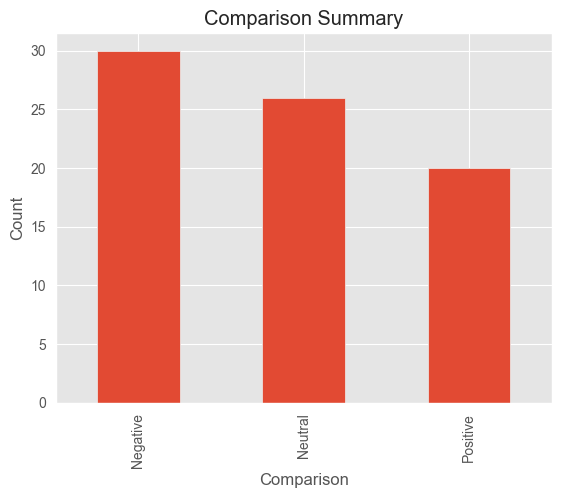

In [53]:
# Calculate summary of the 'Comparison' column
summary = df['Comparison'].value_counts()

# Display the summary
print(summary)

# Plot the summary as a bar graph
summary.plot(kind='bar')
plt.xlabel('Comparison')
plt.ylabel('Count')
plt.title('Comparison Summary')
plt.show()